# Extraction of Quartz-GaAs-Quartz layered sample

In [1]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)
    
from Matrix_methods.Simulate import simulate_parallel
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor

bias of sample_pulse before 60 ps: -126.42298178055975
Length of ref_df: 993
Length of sample_df: 993


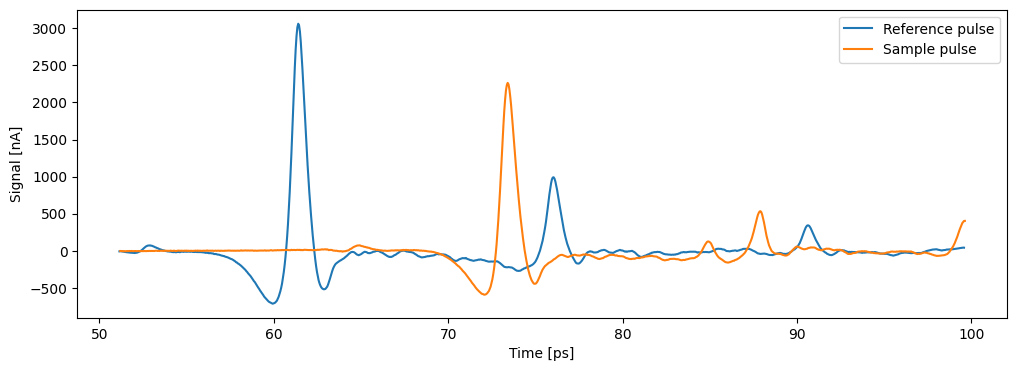

In [2]:
sample_path = 'New_samples_csv/Q_1050um_GaAs_490um_Q_Circle_1040um_15_32_35.csv'
ref_path = 'New_samples_csv/ref_15_28_05.csv'

ref_df = pd.read_csv(ref_path).dropna()
sample_df = pd.read_csv(sample_path).dropna()

# Remove bias from samples
mask = sample_df['Time_ps'] < 60
bias = np.mean(sample_df['Signal'][mask])
print("bias of sample_pulse before 60 ps:", bias)

ref_df['Signal'] -= bias
sample_df['Signal'] -= bias

# Drop first 2 rows from sample_df to match lengths
sample_df = sample_df.iloc[2:].reset_index(drop=True)

print("Length of ref_df:", len(ref_df))
print("Length of sample_df:", len(sample_df))

plt.figure(figsize=(12,4))
plt.plot(ref_df['Time_ps'], ref_df['Signal'], label='Reference pulse')
plt.plot(sample_df['Time_ps'], sample_df['Signal'], label='Sample pulse')
plt.xlabel('Time [ps]')  # Fixed label
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

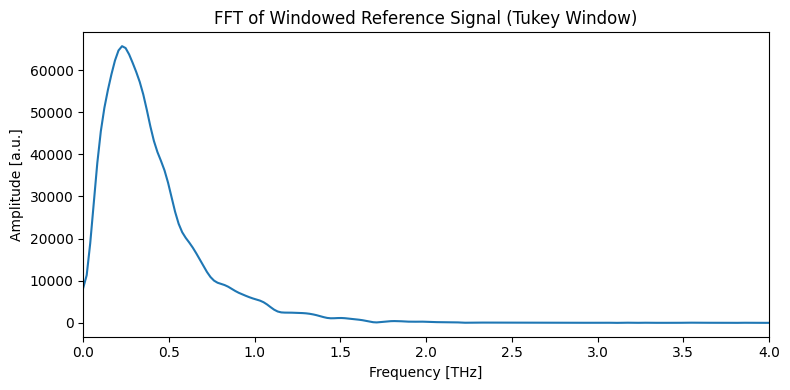

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import tukey

# Extract time and signal
time_ps = ref_df['Time_ps'].values
signal_na = ref_df['Signal'].values

# Convert time to seconds
time_s = time_ps * 1e-12

# Parameters for window
center_ps = 61  # center of pulse in ps
width_ps = 20   # total width around center (adjust if needed)
alpha = 0.5     # Tukey window shape: 0=rectangular, 1=Hann

# Define window bounds
start_ps = center_ps - width_ps / 2
end_ps = center_ps + width_ps / 2

# Create Tukey window mask
mask = (time_ps >= start_ps) & (time_ps <= end_ps)
window = np.zeros_like(signal_na)
tukey_len = np.sum(mask)
window[mask] = tukey(tukey_len, alpha)

# Apply window
windowed_signal = signal_na * window

# FFT
dt = np.mean(np.diff(time_s))
n = len(signal_na)
fft_result = np.fft.fft(windowed_signal)
freq = np.fft.fftfreq(n, d=dt)
freq_thz = freq * 1e-12

# Plot FFT
plt.figure(figsize=(8, 4))
plt.plot(freq_thz[:n//2], np.abs(fft_result[:n//2]))
plt.title('FFT of Windowed Reference Signal (Tukey Window)')
plt.xlabel('Frequency [THz]')
plt.ylabel('Amplitude [a.u.]')
plt.xlim(0, 4)
plt.grid(False)
plt.tight_layout()
plt.show()

## Setup models and filters for fitting

In [4]:
L = len(sample_df['Time_ps'])
n_quartz_1 = 2
n_quartz_2 = 2
n_gaas = 3.4

k_quartz_1 = 0
k_quartz_2 = 0
k_gaas = 0

d_quartz_1 = 1080 * 1e-6 # 1050 um
d_quartz_2 = 1040 * 1e-6 # 1040 um
d_gaas = 490 * 1e-6 # 490 um

deltat = np.diff(ref_df['Time_ps'].to_numpy())[0] # Have checked time steps are uniform
print(f'{deltat} ps')
deltat *= 1e-12

0.048828125 ps


In [5]:
optimize_mask = [
    (True, True, False),  # Quartz 
    (True, True, False),  # GaAs
    (True, True, False)   # Quartz  
]

init_guess = [
    ((n_quartz_1 + 1j*k_quartz_1), d_quartz_1),   # Quartz 
    ((n_gaas + 1j*k_gaas), d_gaas),               # GaAs 
    ((n_quartz_2 + 1j*k_quartz_2), d_quartz_2)    # Quartz
]

# convert pulses to tensors
ref_pulse_t = torch.tensor(ref_df['Signal'].to_numpy(), dtype=torch.float32)
sample_pulse_t = torch.tensor(sample_df['Signal'].to_numpy(), dtype=torch.float32)

print(init_guess)

[((2+0j), 0.00108), ((3.4+0j), 0.00049), ((2+0j), 0.00104)]


Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.9, 2.1)
Layer 1 - k ∈ (-0.01, 0.01)
Layer 2 - n ∈ (3.3, 3.5)
Layer 2 - k ∈ (-0.01, 0.01)
Layer 3 - n ∈ (1.9, 2.1)
Layer 3 - k ∈ (-0.01, 0.01)


/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.1, -0.01, 3.5, 0.01, 2.1, -0.01] before, using random point [2.0792582206518295, -0.006341633571148552, 3.333683518224822, -0.0033855211837044335, 1.9106536108650736, 0.00012727654630850273]
  warnings.warn(


Bayes params: [((2.1-0.006900086341470036j), 0.00108), ((3.5+0.01j), 0.00049), ((2.1-0.01j), 0.00104)]


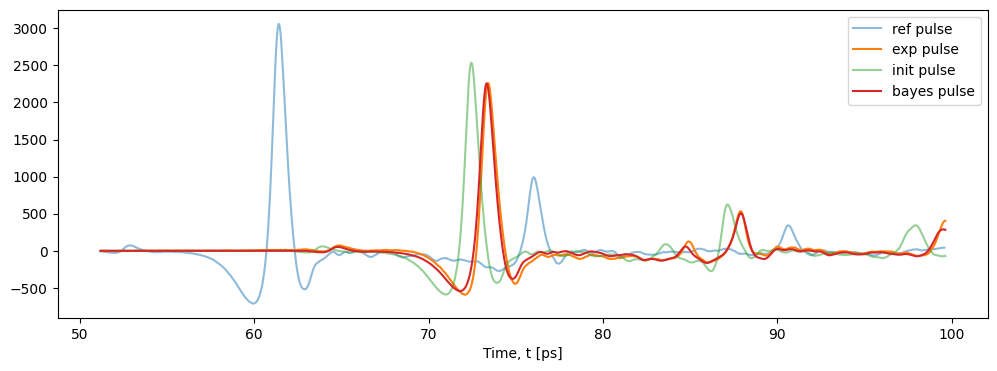

In [6]:
# Simulate pulse with initial guess
init_pulse = simulate_parallel(ref_pulse_t, init_guess, deltat, 0)[1].detach().cpu().numpy()[:L]

Bayes_model = BayesianLayeredExtractor(ref_pulse_t, sample_pulse_t, deltat=deltat, layers_init=init_guess, optimize_mask=optimize_mask)
bayes_params = Bayes_model.bayesian_optimization(n_calls=50)

Bayesian_pulse = simulate_parallel(ref_pulse_t, bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params}')
plt.figure(figsize=(12,4))
plt.plot(ref_df['Time_ps'].to_numpy(), ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(sample_df['Time_ps'].to_numpy(), sample_pulse_t, label='exp pulse')
plt.plot(sample_df['Time_ps'].to_numpy(), init_pulse, label='init pulse', alpha = 0.5)
plt.plot(sample_df['Time_ps'].to_numpy(), Bayesian_pulse, label='bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Fine-tuning 6 parameters for 300 iterations.
Iteration 19, Loss: 3.765731e+01, Layer 0: n=2.1139, k=-0.01406, D=1080.00 µm | Layer 1: n=3.5145, k=0.02071, D=490.00 µm | Layer 2: n=2.1150, k=-0.00487, D=1040.00 µm
Iteration 39, Loss: 3.360836e+01, Layer 0: n=2.1087, k=-0.02943, D=1080.00 µm | Layer 1: n=3.5110, k=0.02139, D=490.00 µm | Layer 2: n=2.1138, k=0.01152, D=1040.00 µm
Iteration 59, Loss: 3.230325e+01, Layer 0: n=2.1075, k=-0.03474, D=1080.00 µm | Layer 1: n=3.5111, k=0.01691, D=490.00 µm | Layer 2: n=2.1180, k=0.01898, D=1040.00 µm
Iteration 79, Loss: 3.153160e+01, Layer 0: n=2.1051, k=-0.03325, D=1080.00 µm | Layer 1: n=3.5091, k=0.01072, D=490.00 µm | Layer 2: n=2.1217, k=0.02013, D=1040.00 µm
Iteration 99, Loss: 3.094483e+01, Layer 0: n=2.1029, k=-0.03336, D=1080.00 µm | Layer 1: n=3.5067, k=0.00617, D=490.00 µm | Layer 2: n=2.1251, k=0.02264, D=1040.00 µm
Iteration 119, Loss: 3.050838e+01, Layer 0: n=2.1009, k=-0.03385, D=1080.00 µm | Layer 1: n=3.5044, k=0.00370, D=490.00

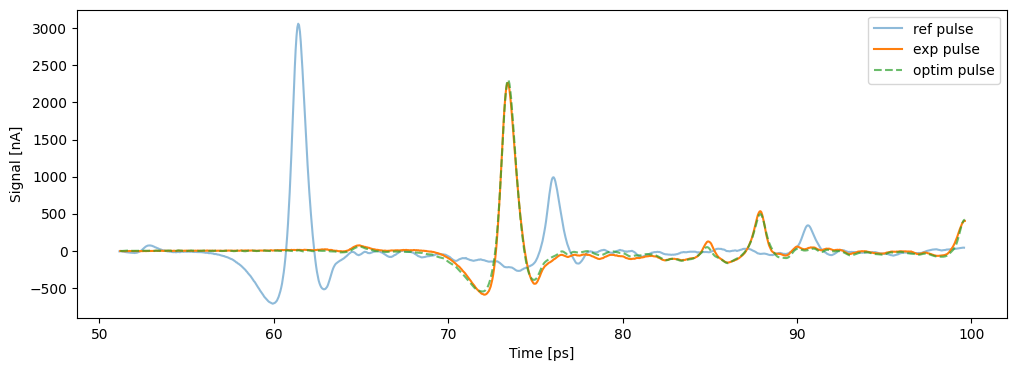

In [7]:
grad_optimizer = LayeredExtractor(ref_pulse_t, sample_pulse_t, deltat, bayes_params, optimize_mask, lr=0.001)
optim_params = grad_optimizer.optimize(num_iterations=300, updates=20, alpha=1)


optim_pulse = simulate_parallel(ref_pulse_t, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(ref_df['Time_ps'].to_numpy(), ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(sample_df['Time_ps'].to_numpy(), sample_pulse_t, label='exp pulse')
plt.plot(sample_df['Time_ps'].to_numpy(), optim_pulse, label='optim pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

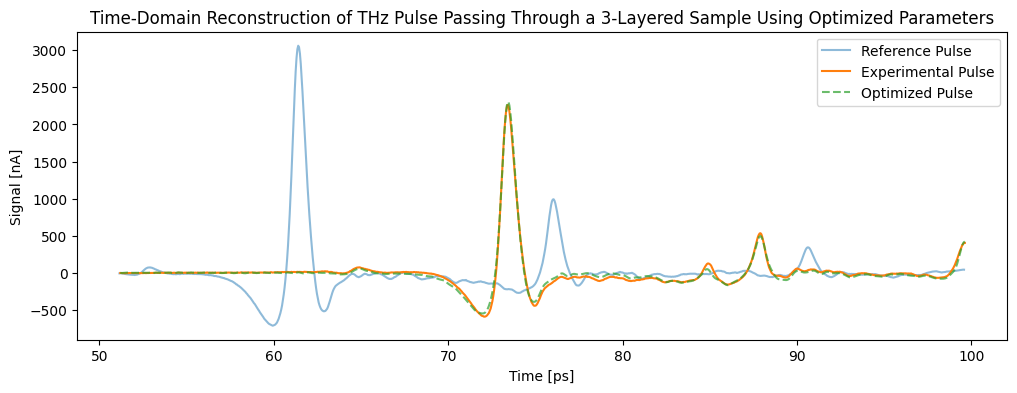

In [8]:
plt.figure(figsize=(12,4))
plt.title('Time-Domain Reconstruction of THz Pulse Passing Through a 3-Layered Sample Using Optimized Parameters')
plt.plot(ref_df['Time_ps'].to_numpy(), ref_pulse_t, label='Reference Pulse', alpha=0.5)
plt.plot(sample_df['Time_ps'].to_numpy(), sample_pulse_t, label='Experimental Pulse')
plt.plot(sample_df['Time_ps'].to_numpy(), optim_pulse, label='Optimized Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

In [9]:
grad_optimizer.best_loss

30.016677856445312

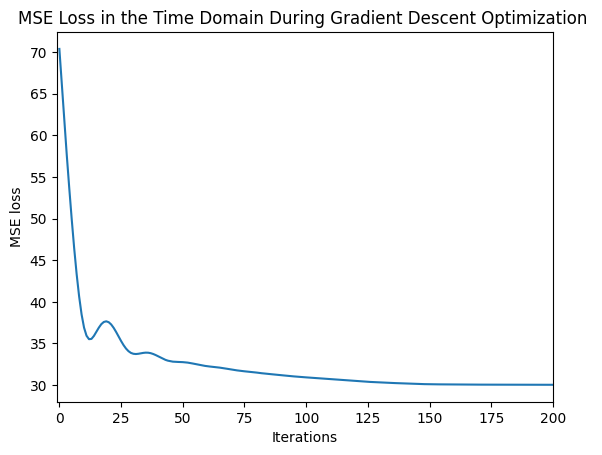

In [10]:
plt.plot(grad_optimizer.loss_history)
plt.title('MSE Loss in the Time Domain During Gradient Descent Optimization ')
plt.xlim(-1,200)
plt.xlabel('Iterations')
plt.ylabel('MSE loss')
plt.show()